In [11]:
# Pip Install If you do not have these packages
# Python version = 3.10
!pip install torch==2.0.1
!pip install numpy==1.24.3
!pip install scikit-learn==1.3.0
!pip install torch-geometric==2.3.1


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 89.4/89.4 kB 4.9 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import numpy as np

# Load graph structure
graph_data = np.loadtxt('blogcatalogue-network.txt', skiprows=1, dtype=np.int64)
edge_index = torch.tensor(graph_data, dtype=torch.long).t().contiguous()

# Load node labels
labels_data = np.loadtxt('blogcatalogue-group.txt', skiprows=1, dtype=np.int64)
labels = torch.zeros((10312, 39))  # Assuming the number of nodes and classes from your provided data
for node_id, class_id in labels_data:
    labels[node_id, class_id] = 1  # It's a multi-label problem

In [68]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(10312, 512)  # 10312 is the number of nodes (also the input dimension), 512 is an arbitrary hidden dimension
        self.conv2 = GCNConv(512, 512)
        self.conv3 = GCNConv(512, 256)
        self.out = torch.nn.Linear(256, 39)  # 39 is the number of classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = self.out(x)
        return torch.sigmoid(x)

In [69]:
from sklearn.model_selection import train_test_split

# Create a dictionary where keys are class labels, and values are lists of nodes
class_dict = {i: [] for i in range(39)}
for node_id, class_id in labels_data:
    class_dict[class_id].append(node_id)

sorted_classes = sorted(class_dict.items(), key=lambda item: len(item[1]))

# Split the nodes of each class into train and test, ensure no overlap
train_nodes = set()
test_nodes = set()
for class_id, nodes in sorted_classes:
    if len(nodes) == 1:  # if only one node for this class, add it to train set
        train_nodes.add(nodes[0])
    else:
        train, test = train_test_split(nodes, test_size=0.5, random_state=42)
        train = [node for node in train if node not in test_nodes]  # ensure train nodes are not in test set
        test = [node for node in test if node not in train_nodes]  # ensure test nodes are not in train set
        train_nodes.update(train)
        test_nodes.update(test)

# Check if all classes are represented in the test set
test_classes = [class_id for node_id, class_id in labels_data if node_id in test_nodes]
missing_classes = set(range(39)) - set(test_classes)

# If some classes are missing in the test set, move one node of each missing class from train to test
for class_id in missing_classes:
    for node_id in train_nodes:
        if class_id in labels_data[node_id]:
            train_nodes.remove(node_id)
            test_nodes.add(node_id)
            break

train_mask = torch.tensor(list(train_nodes), dtype=torch.long)
test_mask = torch.tensor(list(test_nodes), dtype=torch.long)

print(train_mask.shape)
print(test_mask.shape)


torch.Size([5153])
torch.Size([5159])


In [70]:
from torch_geometric.data import Data
from torch.optim import Adam
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Preparing the data
x = torch.eye(10312, dtype=torch.float)  # One-hot encoded input features
data = Data(x=x, edge_index=edge_index, y=labels)


# Class labels in a multi-label binary format
y = labels.detach().cpu().numpy()  # Convert labels tensor to a NumPy array
data.train_mask = train_mask
data.test_mask = test_mask
data = data.to(device)

# Setting up the model and optimizer
model = GNN().to(device)
optimizer = Adam(model.parameters(), lr=0.01)


class_counts = y.sum(axis=0)  # count the number of positive examples for each class
class_weights = 1. / class_counts  # compute the inverse frequency
class_weights = class_weights / class_weights.sum()  # normalize the weights so they sum to 1

# Training the model
model.train()
for epoch in range(1200):  # For simplicity, we just loop 200 epochs
    optimizer.zero_grad()
    out = model(data)
    loss = F.binary_cross_entropy(out[data.train_mask], data.y[data.train_mask], weight=torch.tensor(class_weights, device=device))
    loss.backward()
    optimizer.step()
    if epoch % 50 == 49 and epoch > 0:
        print(f'{epoch+1} epochs has passed')

print('training completed')

cuda
50 epochs has passed
100 epochs has passed
150 epochs has passed
200 epochs has passed
250 epochs has passed
300 epochs has passed
350 epochs has passed
400 epochs has passed
450 epochs has passed
500 epochs has passed
550 epochs has passed
600 epochs has passed
650 epochs has passed
700 epochs has passed
750 epochs has passed
800 epochs has passed
850 epochs has passed
900 epochs has passed
950 epochs has passed
1000 epochs has passed
1050 epochs has passed
1100 epochs has passed
1150 epochs has passed
1200 epochs has passed
F1 Score for each class: [0.01388889 0.1934236  0.31263383 0.01190476 0.11849192 0.16165414
 0.61188811 0.33333333 0.09243697 0.09966777 0.42440318 0.09090909
 0.18021978 0.18565401 0.03508772 0.10948905 0.17821782 0.03463203
 0.1722488  0.19607843 0.38938053 0.11304348 0.20454545 0.33578792
 0.05464481 0.07207207 0.06666667 0.18518519 0.11363636 0.0244898
 0.04395604 0.12297735 0.14814815 0.11111111 0.05194805 0.01923077
 0.07843137 0.02898551 0.11764706]


In [72]:
# Testing the model
model.eval()
with torch.no_grad():
    predictions = model(data)
    pred = predictions[data.test_mask].detach().cpu().numpy()
    true = data.y[data.test_mask].detach().cpu().numpy()


# Use the same prediction and true tensors as before
f1_scores = f1_score(true, pred > 0.5, average=None, zero_division=1)

print(f"F1 Score for each class: {f1_scores}")

F1 Score for each class: [0.01388889 0.1934236  0.31263383 0.01190476 0.11849192 0.16165414
 0.61188811 0.33333333 0.09243697 0.09966777 0.42440318 0.09090909
 0.18021978 0.18565401 0.03508772 0.10948905 0.17821782 0.03463203
 0.1722488  0.19607843 0.38938053 0.11304348 0.20454545 0.33578792
 0.05464481 0.07207207 0.06666667 0.18518519 0.11363636 0.0244898
 0.04395604 0.12297735 0.14814815 0.11111111 0.05194805 0.01923077
 0.07843137 0.02898551 0.11764706]


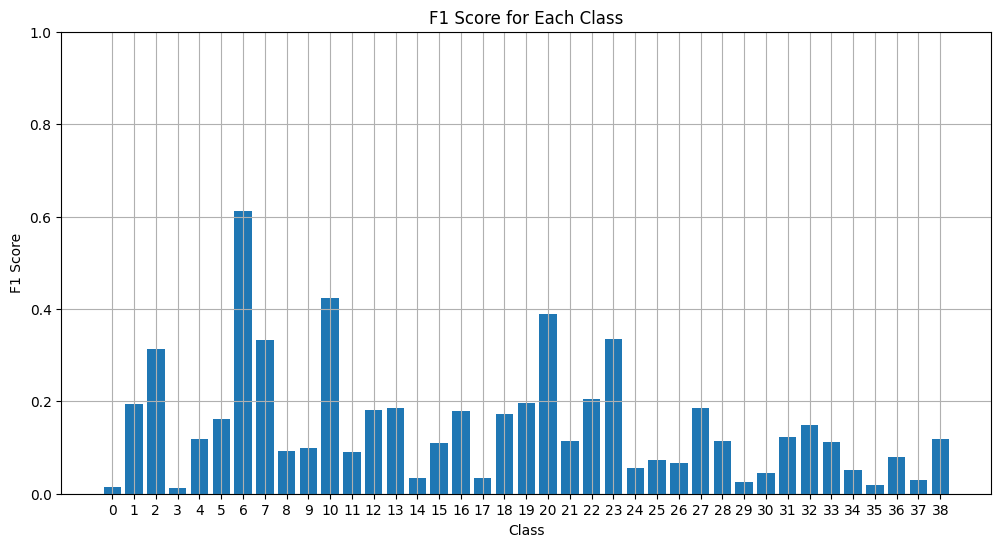

In [71]:
# Plotting
import matplotlib.pyplot as plt

# Assume f1_scores is the array of F1 scores calculated as before
classes = range(len(f1_scores))

plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(classes, f1_scores)  # Create a bar chart
plt.xlabel('Class')  # Set x-axis label
plt.ylabel('F1 Score')  # Set y-axis label
plt.title('F1 Score for Each Class')  # Set plot title
plt.xticks(classes)  # Set x-tick labels to be the classes
plt.ylim([0, 1])  # Optional: you might want to set y limits to [0, 1] as F1 Score is between 0 and 1
plt.grid(True)  # Optional: add a grid for better visualization
plt.show()